In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio
import librosa

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething
from morse.models import SimpleCNN, UNetModel
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
# from morse.augmentations import rotation_transform, volume_signal_transform
from morse.augmentations import make_volume_signal_transform, make_compose_transform, make_noise_signal_transform, make_runtime_rotation_transform, make_runtime_mel_bounded_noise_transform, make_mel_pad_augmentation, make_mel_feature_extraction_transform, normalize_mel_spec
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.my_datasets import generate_dataset, read_dataset_from_files

In [6]:
labels_dir = '../'
audio_dir = '../morse_dataset'


dev_flag = True


full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [7]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)

val_index = val_index[:100]

real_val_set = read_dataset_from_files(audio_dir, 
                                       filenames = full_train_df.iloc[val_index]['id'], 
                                       labels=list(full_train_df.iloc[val_index]['message']), 
                                       mel_spec_transform=make_compose_transform([make_mel_pad_augmentation(),
                                                                                  make_mel_feature_extraction_transform(4)]))
print(len(real_val_set))

# real_train_set = read_dataset_from_files(audio_dir, 
#                                        filenames = full_train_df.iloc[train_index]['id'], 
#                                        labels=list(full_train_df.iloc[train_index]['message']))
# print(len(real_train_set))

100%|██████████| 100/100 [00:00<00:00, 102.05it/s]

100


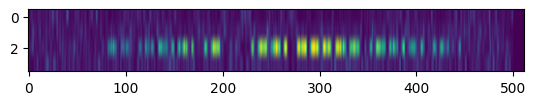

In [9]:
plt.imshow(real_val_set[0][0], aspect=16)

In [ ]:
# def make_regular_block

UNetModel(d_input=4, d_model=64, d_output=5, n_down=4, n_up=4, make_regular_block=)

In [6]:
batch = torch.tensor([el[0].numpy() for el in real_val_set])
batch.shape

torch.Size([100, 64, 512])

In [7]:
def make_test_block():
    return CNNResidualBlock(d_model=64, d_inner=64)

# only well padded inputs

PartialFlatUNetBlock(n_down=4, n_up=4, make_regular_block=make_test_block, central_block=make_test_block(), 
                     make_downsample_transition=lambda: nn.Conv1d(64, 64, kernel_size=2, stride=2, padding=0), 
                     make_upsample_transition=lambda: nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=2, stride=2,
                                                                          padding=0))(batch).shape

torch.Size([100, 64, 64]) torch.Size([100, 64, 64])
torch.Size([100, 64, 128]) torch.Size([100, 64, 128])
torch.Size([100, 64, 256]) torch.Size([100, 64, 256])
torch.Size([100, 64, 512]) torch.Size([100, 64, 512])


torch.Size([100, 64, 512])